# Build a Predictive Time Series Model for Larcenies

import python modules

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

set figure size

In [3]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)

# Section 0: Load the data and clean

read the raw data set from CSV file

In [4]:
df = pd.read_csv("APD_Public_Incident_Data__Crime_Locations.csv")

In [5]:
print("number of columns {}".format(len(df.columns)))
print("number of rows {}".format(df['OBJECTID'].count()))

number of columns 17
number of rows 99306


In [6]:
df['incident_dt'] = pd.to_datetime(df['date_occurred'])

In [7]:
df.index = df['incident_dt']

# Section 1: Larceny theft over time

Definition. The FBI's Uniform Crime Reporting (UCR) Program defines larceny-theft as the unlawful taking, carrying, leading, or riding away of property from the possession or constructive possession of another.

In [8]:
larceny_incidents = df[df['offense_group_short_description'] == 'LARCENY - THEFT']

In [9]:
larceny_incidents['incident_dt'].count()

27657

lets roll up the events up by month and study the pattern over time

In [10]:
larceny_monthly_counts = larceny_incidents['offense_short_description'].resample('M').count()

In [11]:
larceny_monthly_counts.head()

incident_dt
2005-01-31    173
2005-02-28    157
2005-03-31    157
2005-04-30    182
2005-05-31    189
Freq: M, Name: offense_short_description, dtype: int64

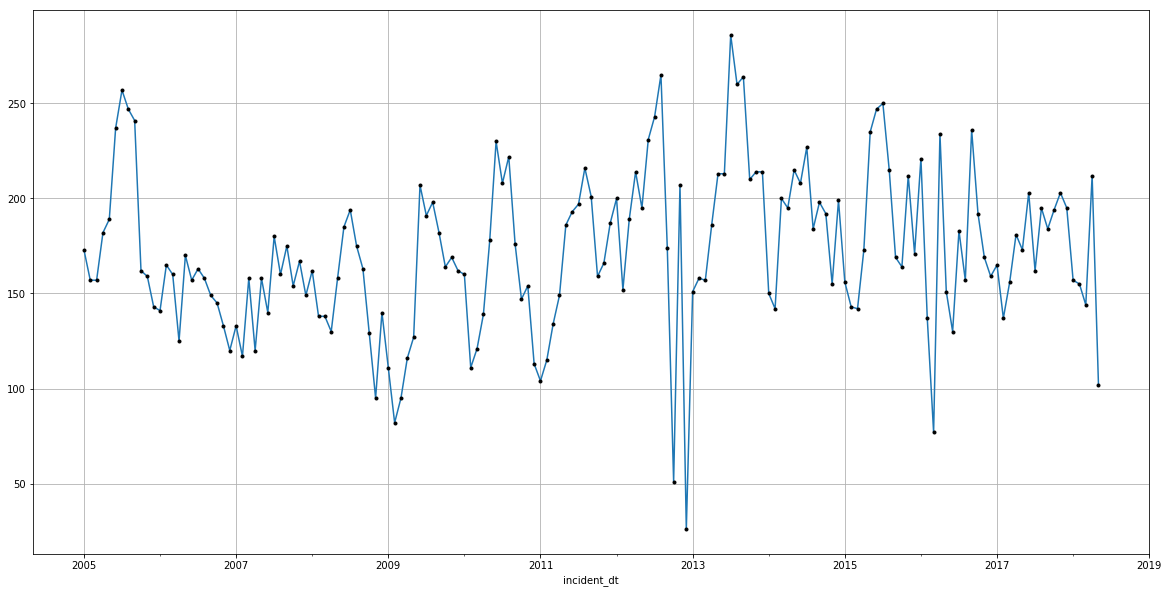

In [12]:
larceny_monthly_counts.plot()
larceny_monthly_counts.plot(style='k.', grid=True)

## Section 1.1 Modeling the data with a time series analysis

We decompose the data into three components:
- Trend over time
- Seasonal cycles 
- "Noise"/Randomness

https://machinelearningmastery.com/grid-search-arima-hyperparameters-with-python/

In [13]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

In [14]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	train_size = int(len(X) * 0.66)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s MSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 

In [60]:
lar_series = larceny_monthly_counts

Specifically for your model, ARIMA(1, 0, 12) means that it you are describing some response variable (Y) by combining a 1st order Auto-Regressive model and a 12th order Moving Average model. A good way to think about it is (AR, I, MA). This makes your model look the following, in simple terms:

Y = (Auto-Regressive Parameters) + (Moving Average Parameters)

The 0 in the between the 1 and the 12 represents the 'I' part of the model (the Integrative part) and it signifies a model where you're taking the difference between response variable data - this can be done with non-stationary data and it doesn't seem like you're dealing with that, so you can just ignore it.



In [16]:
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [17]:
p_values = [11,12,13]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")

In [18]:
# evaluate_models(series.values, p_values, d_values, q_values)

In [78]:
X = lar_series.values
order = (12, 0, 3)
train_size = int(len(X) * 0.90)
train, test = X[0:train_size], X[train_size:]
history = [x for x in train]
# make predictions
predictions = list()

model = ARIMA(history, order=order)
model_fit = model.fit(disp=0)
# yhat = model_fit.forecast()[0]

In [73]:
forecast = model_fit.predict(start=len(history), end=len(X))

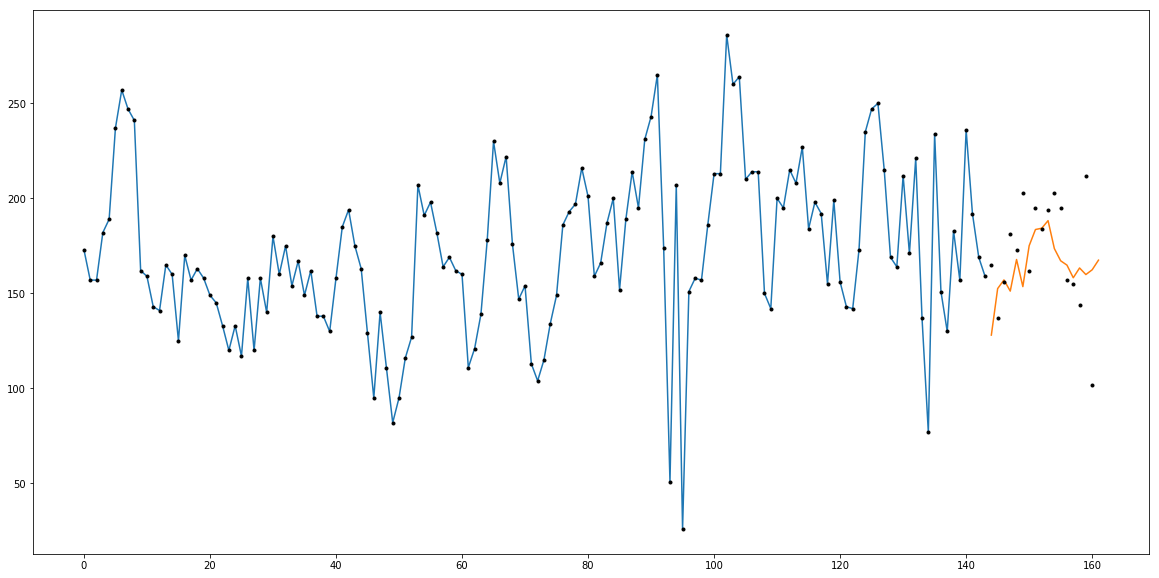

In [74]:
plt.plot(train)
plt.plot([None for i in train] + [x for x in forecast])
pd.Series(X).plot(style='k.')

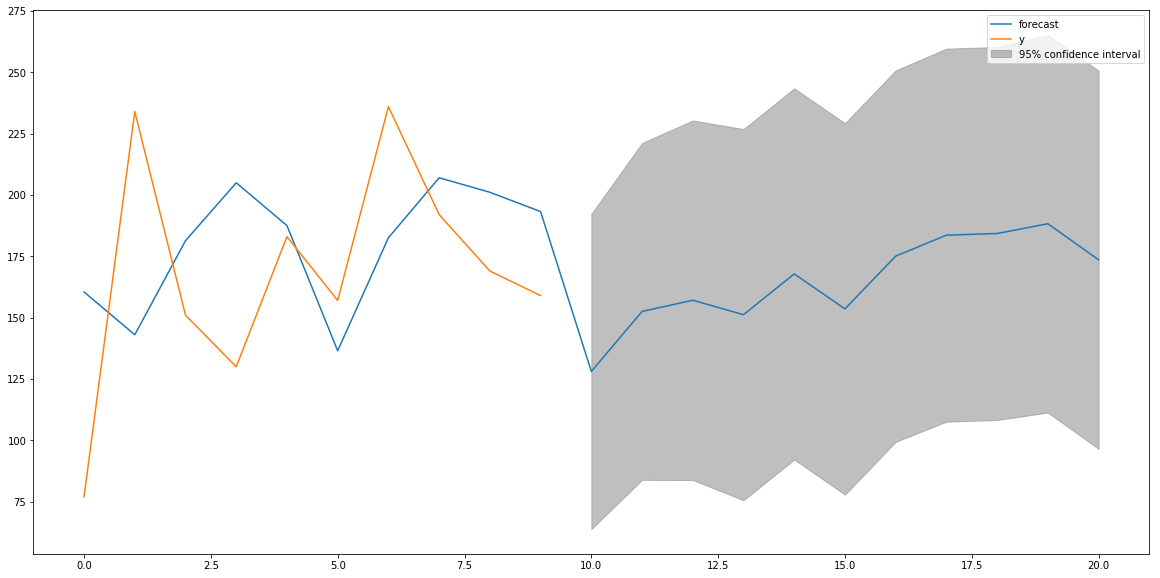

In [76]:
fig = model_fit.plot_predict(len(train)-10, len(train)+10)

In [ ]:
len()